# 数据预处理

## 提取出全部的图片

In [72]:
import os
import shutil
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_path = "./data"
train_path = "./train/"
test_path = "./test/"
train_files = [ f for f in os.listdir("train") if not f.startswith('.')]
test_files = [ f for f in os.listdir("test") if not f.startswith('.')]
print(len(train_files),train_files[0:10])
print(len(test_files),test_files[0:10])

25000 ['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg', 'cat.10151.jpg', 'cat.3406.jpg', 'dog.1753.jpg', 'cat.4369.jpg', 'cat.7660.jpg', 'dog.5535.jpg']
12500 ['9733.jpg', '63.jpg', '6400.jpg', '823.jpg', '4217.jpg', '3578.jpg', '10321.jpg', '2666.jpg', '5109.jpg', '11981.jpg']


图片大小的分布图

142.92948293685913
width means value is : 360.47808
width min value is : 32
width max value is : 768
width median value is : 374.0
height means value is : 404.09904
height min value is : 42
height max value is : 1050
height median value is : 447.0


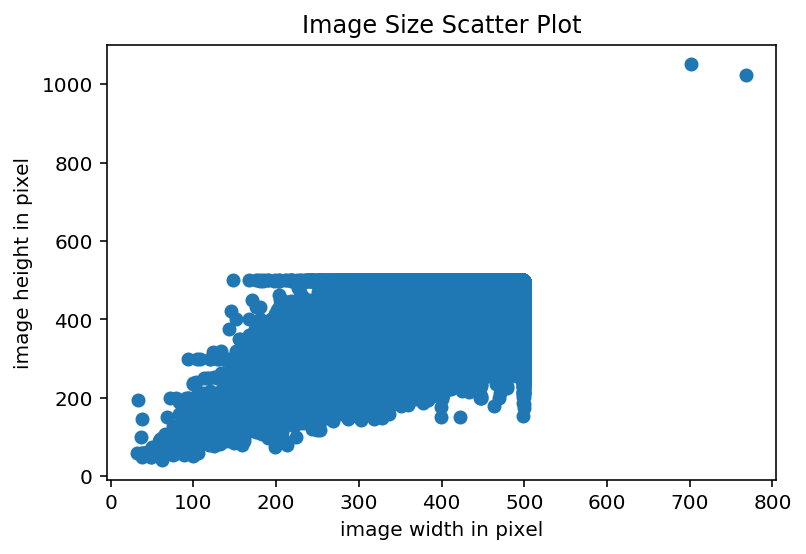

In [75]:
# 获取训练图片的大小分布图
def get_images_distribution():
    images_size_list = []
    images_origin = []
    for image in train_files:
        img = cv2.imread(train_path + "/" + image)
        size = img.shape[:2]
        images_size_list.append(size)
        images_origin.append(img)
    return images_size_list,images_origin
start = time.time()
images_size_list,images_origin = get_images_distribution()
print(time.time() - start)

# 作出训练数据的分布图
xb = [ t[0] for t in images_size_list]
yb = [ t[1] for t in images_size_list]
plt.scatter(xb,yb)
plt.title('Image Size Scatter Plot')
plt.xlabel('image width in pixel')
plt.ylabel('image height in pixel')

print("width means value is :", np.mean(xb))
print("width min value is :", np.min(xb))
print("width max value is :", np.max(xb))
print("width median value is :", np.median(xb))
print("height means value is :", np.mean(yb))
print("height min value is :", np.min(yb))
print("height max value is :", np.max(yb))
print("height median value is :", np.median(yb))

In [77]:
print("width variance is:", np.var(xb),", height variance is: ",np.var(yb))
print("width std is:", np.std(xb),", height std is: ",np.std(yb))

width variance is: 9412.49599951 , height variance is:  11888.7945911
width std is: 97.0180189424 , height std is:  109.035749143


数据展示

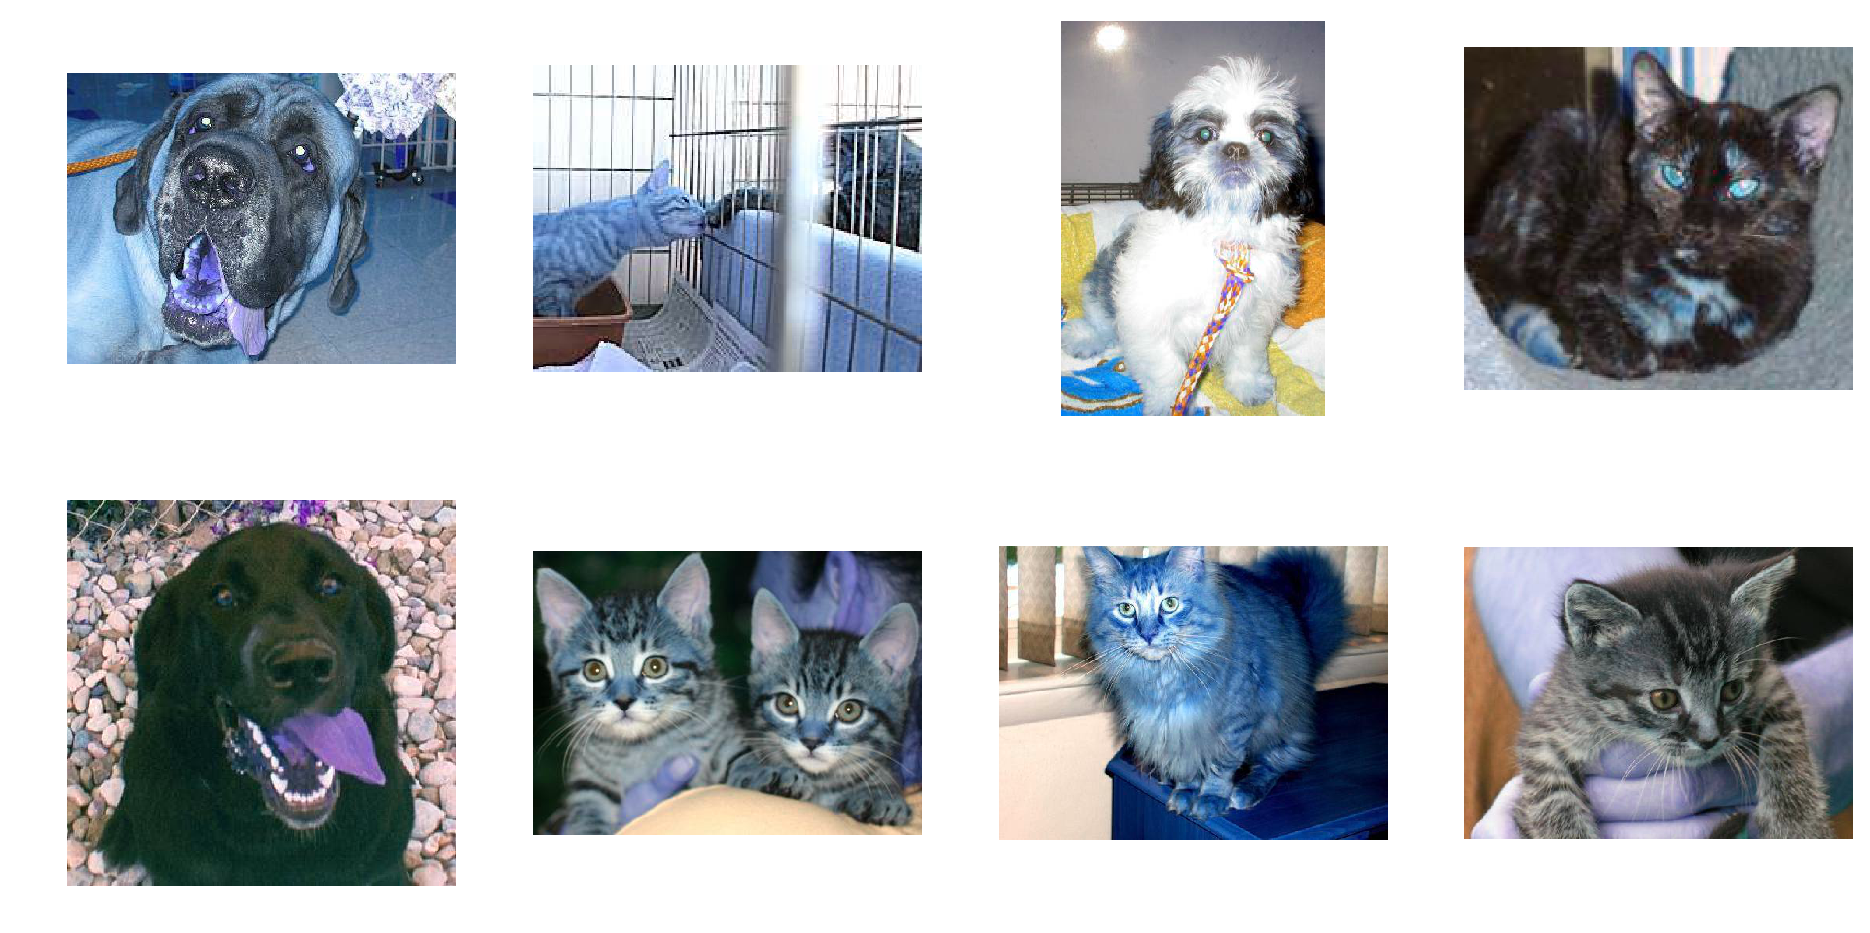

In [64]:
import random
random.seed(2018)
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(241+i)
    plt.imshow(images_origin[random.randint(0,len(train_files))])
    plt.axis('off')
plt.show()

训练图片

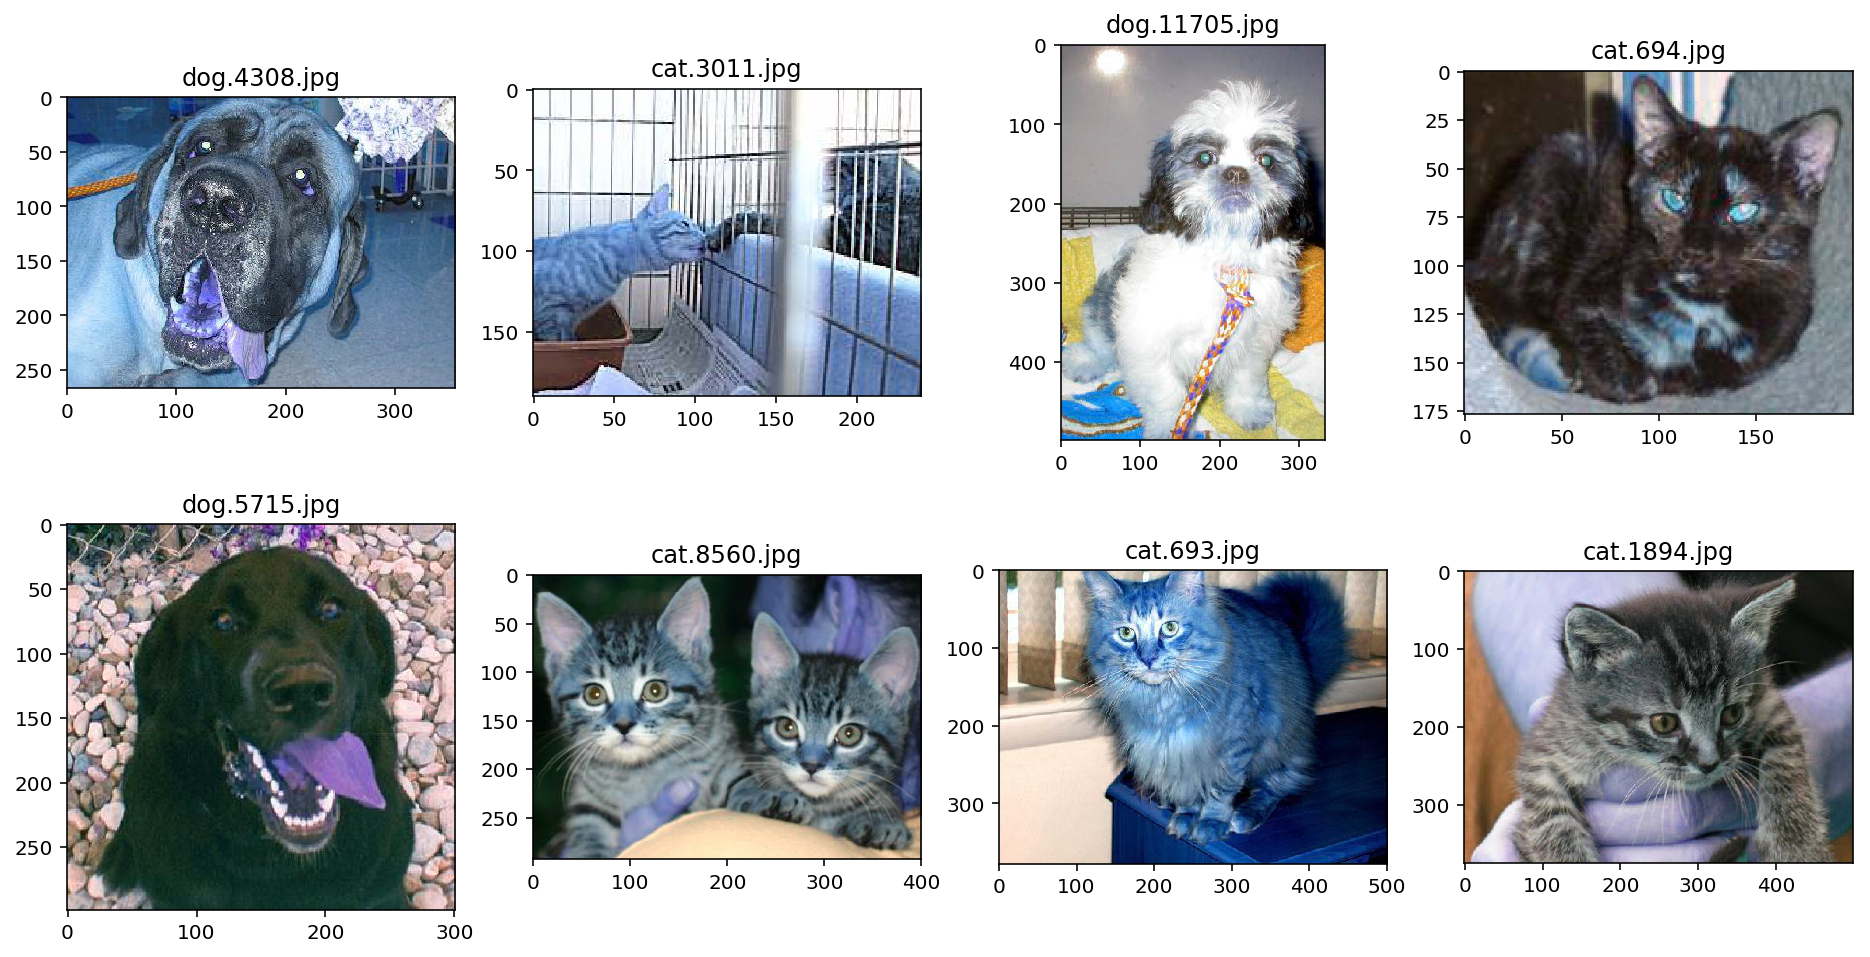

In [68]:
random.seed(2018)
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(241+i)
    r = random.randint(0,len(train_files))
    plt.imshow(images_origin[r])
    plt.title(train_files[r])
#     plt.axis('off')
plt.show()

测试图片

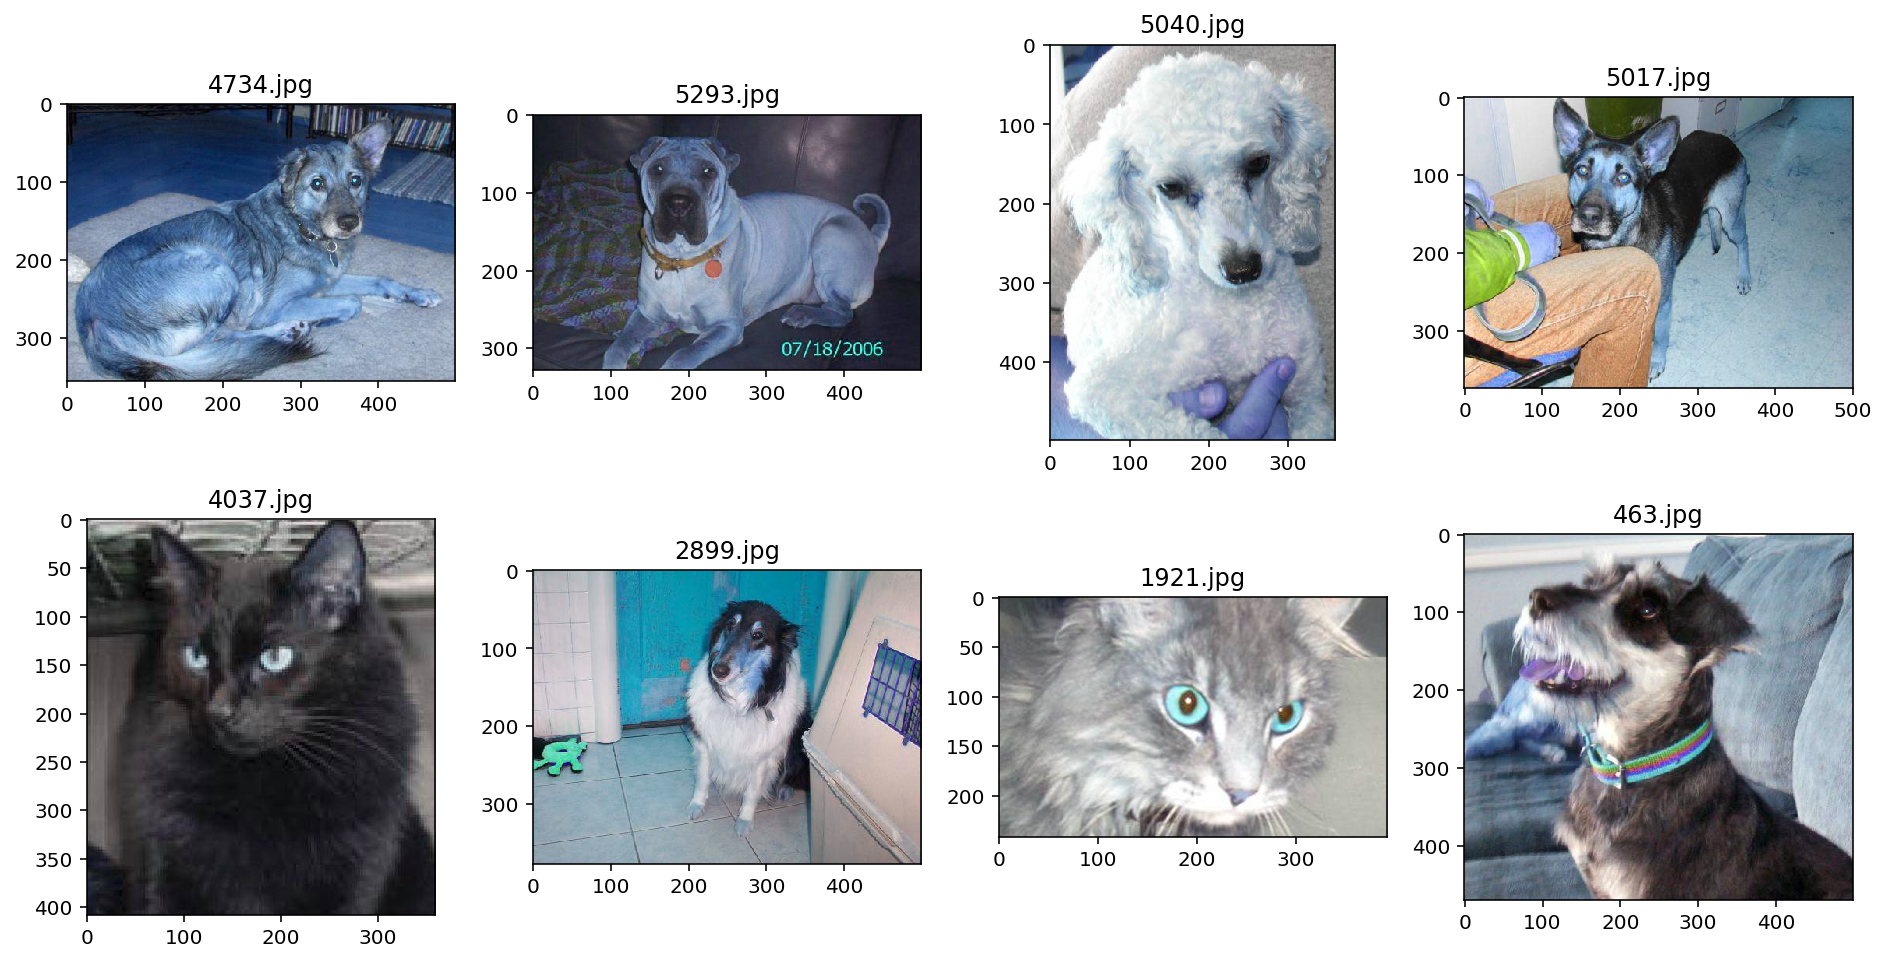

In [71]:
random.seed(2018)
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(241+i)
    r = random.randint(0,len(test_files))
    img = cv2.imread(test_path + "/" + test_files[r])
    plt.imshow(img)
    plt.title(test_files[r])
#     plt.axis('off')
plt.show()

## 数据切分

In [97]:
from sklearn.model_selection import train_test_split
# 切分训练数据
img_train, img_cv = train_test_split(train_files, test_size=0.2, random_state=32)
print(len(img_train), len(img_cv))

20000 5000


从训练文件中分出猫和狗的图片，将其在 data 目录中分别存储到 train 和 valid 下。

In [ ]:
# 创建所需要的目录
def mkdir_img():
    train_root = data_path + "/train"
    valid_root = data_path + "/valid"
    test_root = data_path + "/test"
    train_cats = train_root + "/cats/"
    train_dogs = train_root + "/dogs/"
    valid_cats = valid_root + "/cats/"
    valid_dogs = valid_root + "/dogs/"
    test_sub = test_root + "/test/"
    if os.path.exists(train_root):
        shutil.rmtree(train_root)
    if os.path.exists(valid_root):
        shutil.rmtree(valid_root)
    if os.path.exists(test_root):
        shutil.rmtree(test_root)
        
    os.mkdir(train_root)
    os.mkdir(valid_root)  
    os.mkdir(train_cats)
    os.mkdir(train_dogs)
    os.mkdir(valid_cats)
    os.mkdir(valid_dogs)
    os.mkdir(test_root)
    os.mkdir(test_sub)
    
# 将训练数据与验证数据分目录
def separate_imgs():
    # 训练数据
    for img in img_train:
        if "cat" in img:
            shutil.copyfile(train_path + img, data_path + "/train/cats/" + img )
        if "dog" in img:
            shutil.copyfile(train_path + img, data_path + "/train/dogs/" + img )
    
    # 验证数据
    for img in img_cv:
        if "cat" in img:
            shutil.copyfile(train_path + img, data_path + "/valid/cats/" + img )
        if "dog" in img:
            shutil.copyfile(train_path + img, data_path + "/valid/dogs/" + img )
    
    # 测试数据
    for img in test_files:
        shutil.copyfile(test_path + img, data_path + "/test/test/" + img )
    
start = time.time() 
mkdir_img()
separate_imgs()
print(time.time() - start) 

# 导出特征
## 生成测试与验证数据

In [12]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
import h5py

# 设定 Xception 图片的大小
width,height=299,299
image_size = (width,height)

# 生成训练与验证图片
gen = ImageDataGenerator()
train_generator = gen.flow_from_directory(
        'data/train',
        target_size=image_size,
        shuffle=False,
        batch_size=16)
validation_generator = gen.flow_from_directory(
        'data/valid',
        target_size=image_size, 
        shuffle=False,
        batch_size=16)

test_generator = gen.flow_from_directory("data/test", target_size=image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

Using TensorFlow backend.


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## 导出特征向量
此处需要较长的时间才可以完成训练

In [ ]:
input_tensor = Input((height, width, 3))
x = input_tensor
x = Lambda(xception.preprocess_input)(x)

base_model = Xception(input_tensor=x, weights='imagenet', include_top=False)
model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

train = model.predict_generator(train_generator)
validation = model.predict_generator(validation_generator)
test = model.predict_generator(test_generator)
with h5py.File("xceptionV5.h5") as h:
    h.create_dataset("train", data=train)
    h.create_dataset("label", data=train_generator.classes)
    h.create_dataset("validation", data=validation)
    h.create_dataset("v_label", data=validation_generator.classes)
    h.create_dataset("test", data=test)

### 载入特征向量

In [105]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)
X_train = []
X_test = []
X_val = []
with h5py.File("xceptionV5.h5", 'r') as h:
    print(h['train'],"\n",h['label'],"\n",h['validation'],"\n",h['v_label'],"\n",h['test'])
    X_train.append(np.array(h['train']))
    X_val.append(np.array(h['validation']))
    X_test.append(np.array(h['test']))
    y_train = np.array(h['label'])
    y_val = np.array(h['v_label'])
X_train = np.concatenate(X_train, axis=1)
X_val = np.concatenate(X_val, axis=1)
X_test = np.concatenate(X_test, axis=1)
X_train, y_train = shuffle(X_train, y_train)

<HDF5 dataset "train": shape (20000, 2048), type "<f4"> 
 <HDF5 dataset "label": shape (20000,), type "<i4"> 
 <HDF5 dataset "validation": shape (5000, 2048), type "<f4"> 
 <HDF5 dataset "v_label": shape (5000,), type "<i4"> 
 <HDF5 dataset "test": shape (12500, 2048), type "<f4">


### 模型构建

In [119]:
from keras.models import *
from keras.layers import *
np.random.seed(2018)
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 模型结构图

In [107]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________
None


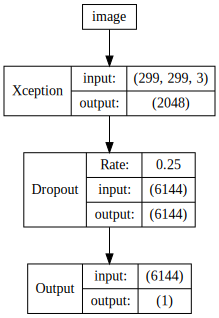

In [123]:
from graphviz import Digraph
g = Digraph('g',node_attr={'shape': 'record', 'height': '.1'})
g.node('node0','image')
g.node('node3','Xception|{input:|output:}|{(299, 299, 3)|(2048)}')
g.node('node5','Dropout|{Rate:|input:|output:}|{0.25|(6144)|(6144)}')
g.node('node6','Output|{input:|output:}|{(6144)|(1)}')

g.edge('node0','node3')
g.edge('node3','node5')
g.edge('node5','node6')
g

### 模型适配

In [120]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10,validation_data=(X_val,y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 57us/step - loss: 0.1522 - acc: 0.9730 - val_loss: 0.0505 - val_acc: 0.9896
Epoch 2/10
20000/20000 [==============================] - 1s 44us/step - loss: 0.0393 - acc: 0.9915 - val_loss: 0.0300 - val_acc: 0.9906
Epoch 3/10
20000/20000 [==============================] - 1s 49us/step - loss: 0.0272 - acc: 0.9932 - val_loss: 0.0246 - val_acc: 0.9916
Epoch 4/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.0245 - acc: 0.9935 - val_loss: 0.0232 - val_acc: 0.9908
Epoch 5/10
20000/20000 [==============================] - 1s 44us/step - loss: 0.0228 - acc: 0.9940 - val_loss: 0.0214 - val_acc: 0.9934
Epoch 6/10
20000/20000 [==============================] - 1s 44us/step - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9916
Epoch 7/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.0198 - acc: 0.9945 - val_loss: 0.0206 - val_acc:

### 训练结果可视化

每步时间

49.0


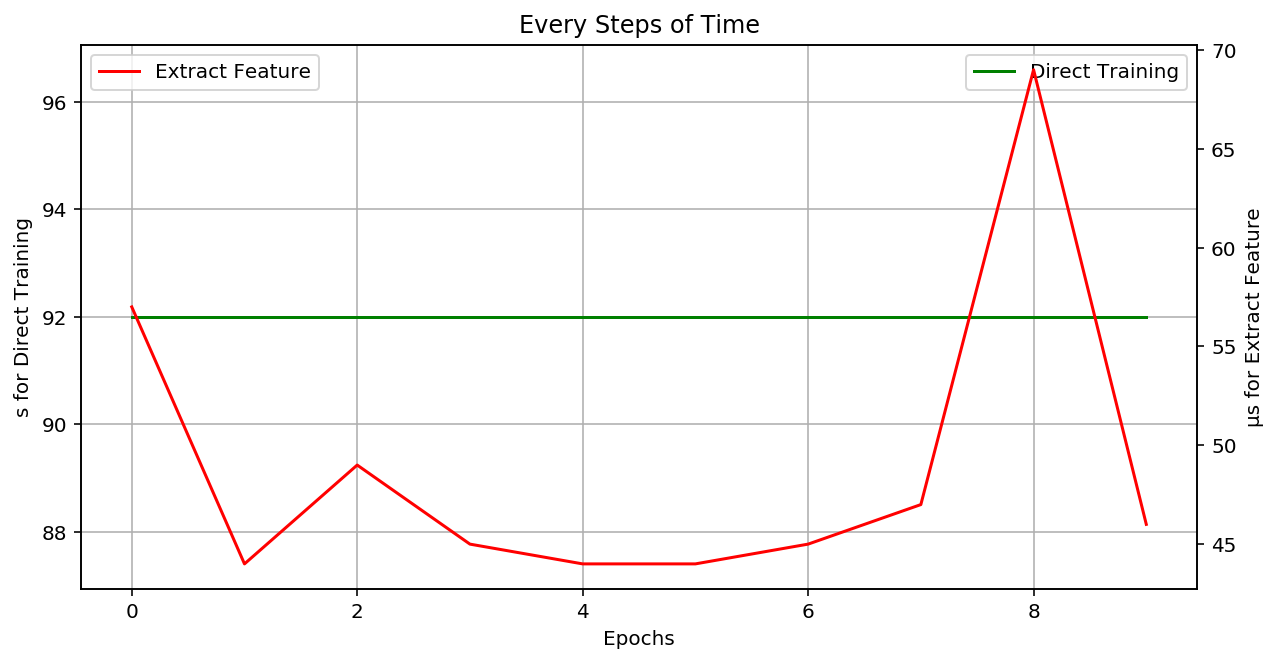

In [167]:
dt_time = [92 for i in range(10)]
ef_time = [57, 44, 49, 45, 44, 44, 45, 47, 69, 46]
plt.figure(figsize=(10, 5))
plt.plot(dt_time, 'g', label="Direct Training")
plt.grid(True)
plt.title('Every Steps of Time')
plt.ylabel('s for Direct Training')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.twinx()
ax2.plot(ef_time, 'r', label="Extract Feature")
ax2.set_ylabel('μs for Extract Feature')
ax2.legend()
print(np.mean(ef_time))

损失与精确度

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


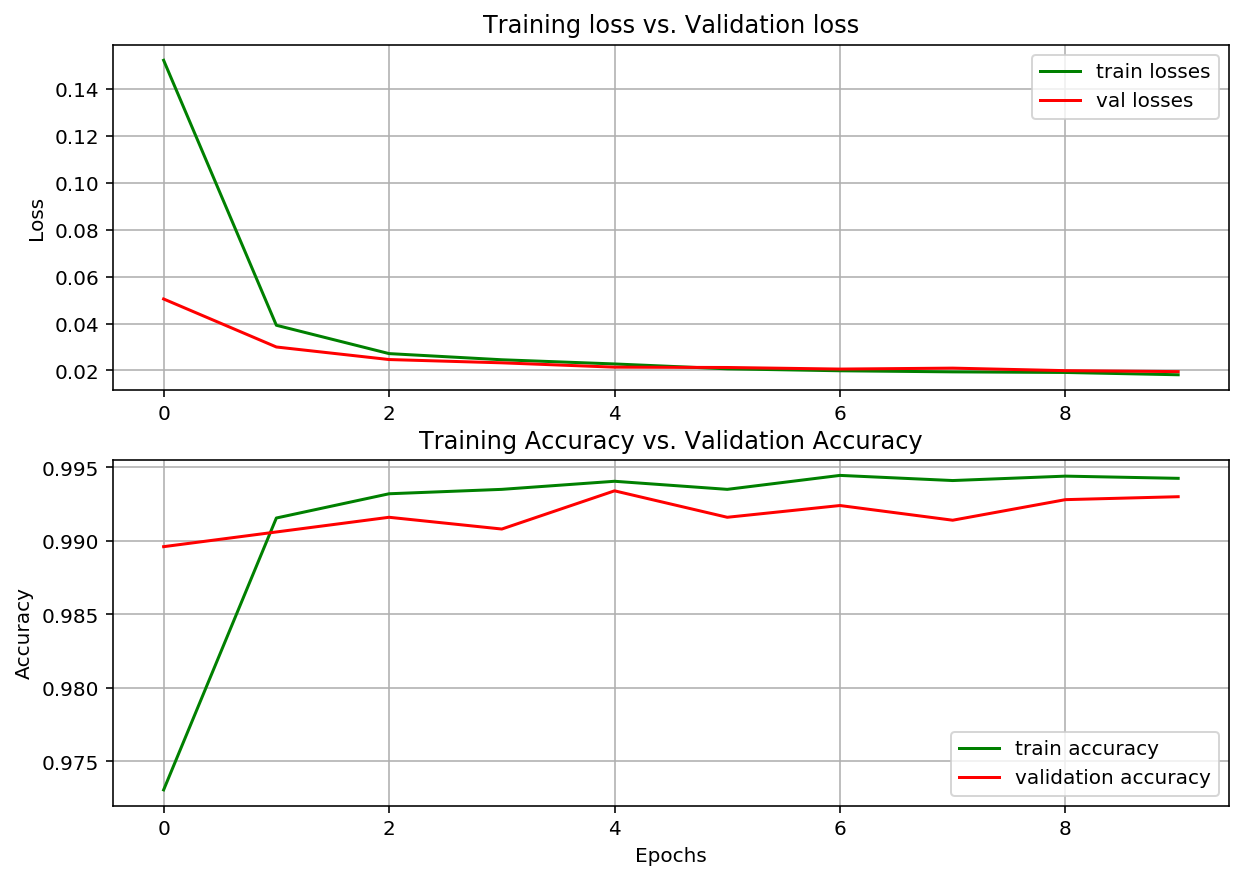

In [146]:
print(history.history.keys())
fig = plt.figure(figsize=(10, 7))
# 训练与验证集的损失
plt.subplot(211)
plt.plot(history.history['loss'], 'g', label="train losses")
plt.plot(history.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 训练与验证的精确度
plt.subplot(212)
plt.plot(history.history['acc'], 'g', label="train accuracy")
plt.plot(history.history['val_acc'], 'r', label="validation accuracy")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [26]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *
df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])
df.to_csv('submissionV5.csv', index=None)
df.head(10)

12500/12500 [==============================] - 0s 33us/step


/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

## 本地化深层特征

In [28]:
print(X_test)

[[ 0.00546482  0.05593672  0.04701887 ...,  0.00420412  0.01056129
   0.0444016 ]
 [ 0.01981659  0.17952396  0.21459933 ...,  0.00871198  0.18446852
   0.62406176]
 [ 0.00598034  0.09484844  0.03249486 ...,  0.23552364  0.18474087
   0.66486382]
 ..., 
 [ 0.          0.10317868  0.77870488 ...,  0.06145926  0.22376971  0.        ]
 [ 0.00214534  0.24859512  0.23865332 ...,  0.08524506  0.0334155
   0.16029772]
 [ 0.26570424  0.22069527  0.19962834 ...,  0.02768794  0.00946932
   0.55510747]]


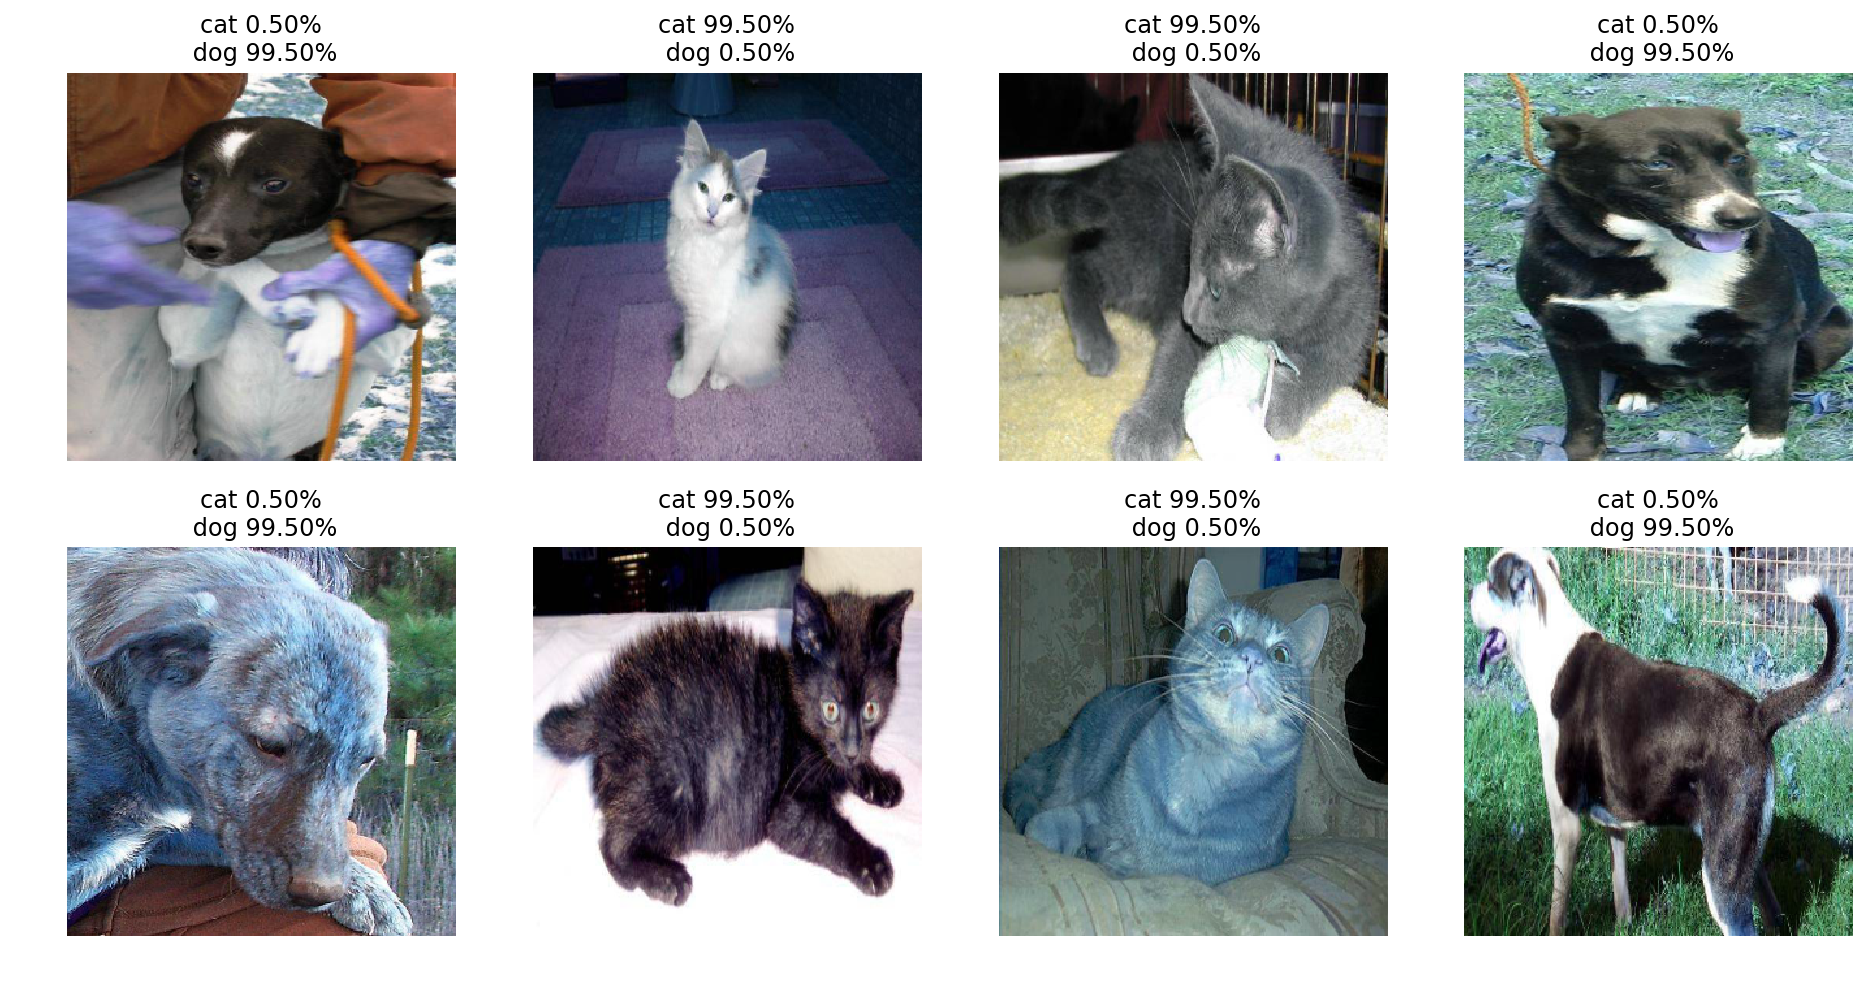

In [65]:
weights = model.layers[-1].get_weights()[0]
plt.figure(figsize=(16,8))
rows = 2
columns = 4
for i, fname in enumerate(test_generator.filenames):
    if i < rows * columns:
        img = cv2.imread(fname)
        img = cv2.resize(img, image_size)
        plt.subplot(rows, columns, i+1)
        plt.title('cat %.2f%%\n dog %.2f%%' % (100 - y_pred[i]*100, y_pred[i]*100))
        plt.axis('off')
        plt.imshow(img)
    else:
        break
plt.show()

## 软件库及其版本

In [147]:
! pip freeze

alabaster==0.7.10
appnope==0.1.0
asn1crypto==0.24.0
Babel==2.5.3
bleach==2.1.3
certifi==2018.1.18
cffi==1.11.5
chardet==3.0.4
cryptography==2.2.1
cycler==0.10.0
decorator==4.2.1
docutils==0.14
entrypoints==0.2.3
graphviz==0.8.2
h5py==2.7.1
html5lib==1.0.1
idna==2.6
imagesize==1.0.0
ipykernel==4.8.2
ipython==6.2.1
ipython-genutils==0.2.0
ipywidgets==7.1.2
jedi==0.11.1
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.5
kiwisolver==1.0.1
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mkl-fft==1.0.0
mkl-random==1.0.1
nbconvert==5.3.1
nbformat==4.4.0
notebook==5.4.1
numpy==1.12.1
numpydoc==0.7.0
packaging==17.1
pandas==0.22.0
pandocfilters==1.4.2
parso==0.1.1
pexpect==4.4.0
pickleshare==0.7.4
prompt-toolkit==1.0.15
protobuf==3.4.1
ptyprocess==0.5.2
pycparser==2.18
pydot==1.2.4
Pygments==2.2.0
pyOpenSSL==17.5.0
pyparsing==2.2.0
PySocks==1.6.8
python-dateutil==2.7.2
pytz==2018.3
PyYAML==3.12
pyzmq==17.0.0
qtconsole==4.

In [126]:
# history
base_model = Xception(include_top=False, weights='imagenet')
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid', name='output')(x)

model = Model(input=base_model.input, output=x)

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# best_model = ModelCheckpoint("xception.h5", monitor='val_loss', verbose=0, save_best_only=True)

model.fit_generator(
        train_generator,
        steps_per_epoch=2048,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=1024,
        callbacks=[best_model])

/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  import sys


KeyboardInterrupt: 

In [145]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## 保存模型参数

In [ ]:
# 输入张量
with open('xception.json', 'w') as f:
    f.write(model.to_json())

# 预测

In [ ]:
# 加载训练好的权重信息
model.load_weights('xception_best.h5')

# 读取测试文件
def get_test_image(index):
    img = cv2.imread(test_path + '/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = len(test_files)
image_matrix = np.zeros((test_num, width, height, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_test_image(i+1)

# 使用模型进行预测
predictions = model.predict(image_matrix, verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions):
    s += '%d,%f\n' % (i+1, p)

with open('submission.csv', 'w') as f:
    f.write(s)

In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Mar 12 2018, 20:05:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [148]:
model.load_weights('xceptionV4.h5')
def get_image(index):
    img = cv2.imread('./data/test/test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = 12500
image_matrix = np.zeros((test_num, width, height, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

predictions = model.predict(image_matrix, verbose=1)
print(predictions)

100%|██████████| 12500/12500 [01:44<00:00, 119.55it/s]


12500/12500 [==============================] - 17545s 1s/step
[[ 0.06371367  0.92587519]
 [ 0.14011283  0.85986751]
 [ 0.05672257  0.94615602]
 ..., 
 [ 0.13139093  0.85618871]
 [ 0.11179256  0.89002883]
 [ 0.62481153  0.34828353]]


In [149]:
s = 'id,label\n'
for i, p in enumerate(predictions):
    s += '%d,%f\n' % (i+1, p[1])

with open('xceptionV4.csv', 'w') as f:
    f.write(s)

## 原始模型可视化
使用 epochs=10 steps_per_epoch=1024,validation_steps=512 得到 xceptionV3 的结果图

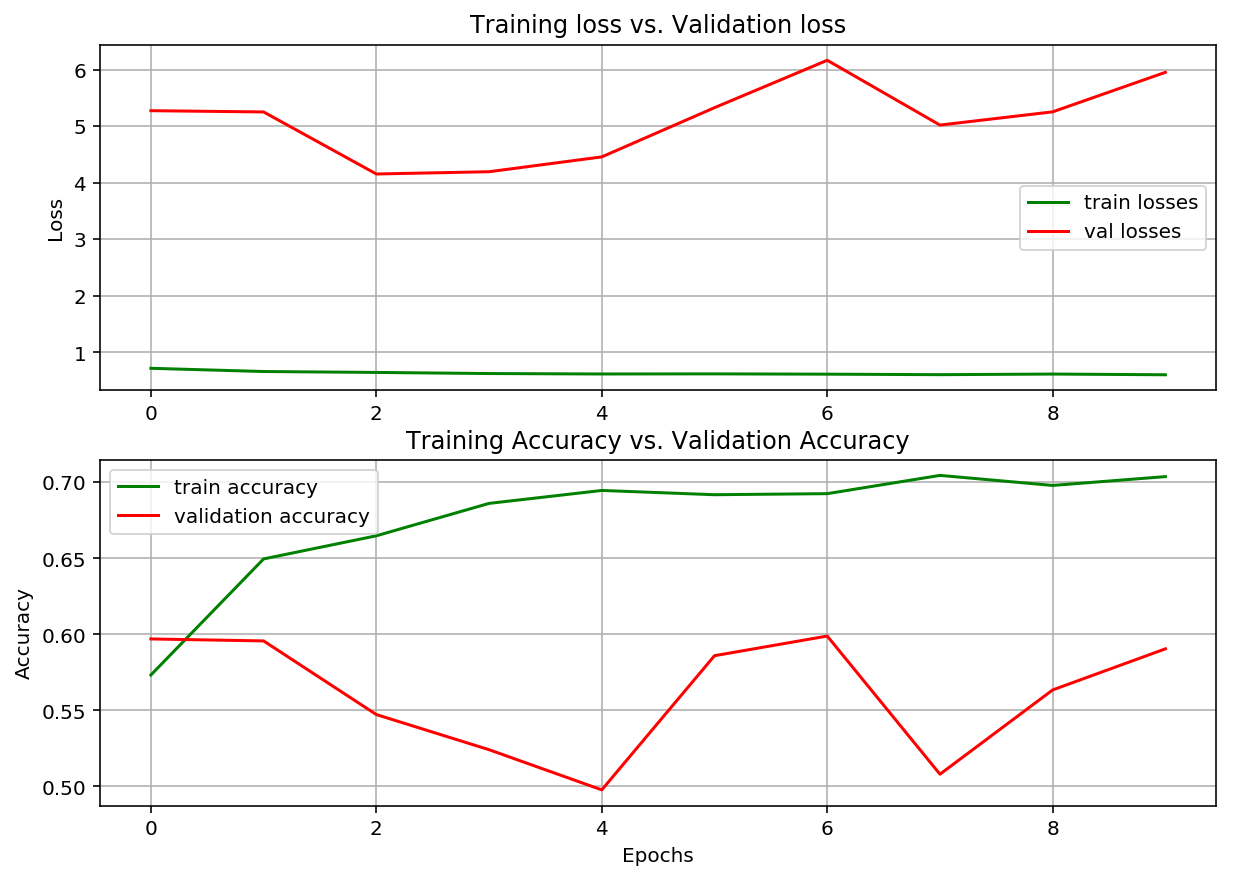

In [142]:
plt.figure(figsize=(10, 7))

# 训练与验证集的损失
loss = [0.7159, 0.6589, 0.6428, 0.6230, 0.6153, 0.6175, 0.6118, 0.6031, 0.6138, 0.6015]
val_loss = [5.2721, 5.2499, 4.1525, 4.1926, 4.4549, 5.3253, 6.1636, 5.0178, 5.2519, 5.9510]
plt.subplot(211)
plt.plot(loss, 'g', label="train losses")
plt.plot(val_loss, 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
# plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()

# 训练与验证的精确度
acc = [0.5732, 0.6495, 0.6647, 0.6860, 0.6945, 0.6917, 0.6924, 0.7044, 0.6978, 0.7036]
val_acc = [0.5969, 0.5956, 0.5472, 0.5241, 0.4977, 0.5859, 0.5988, 0.5080, 0.5634, 0.5904]
plt.subplot(212)
plt.plot(acc, 'g', label="train accuracy")
plt.plot(val_acc, 'r', label="validation accuracy")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

epochs=20 steps_per_epoch=2048,validation_steps=1024,xceptionV4

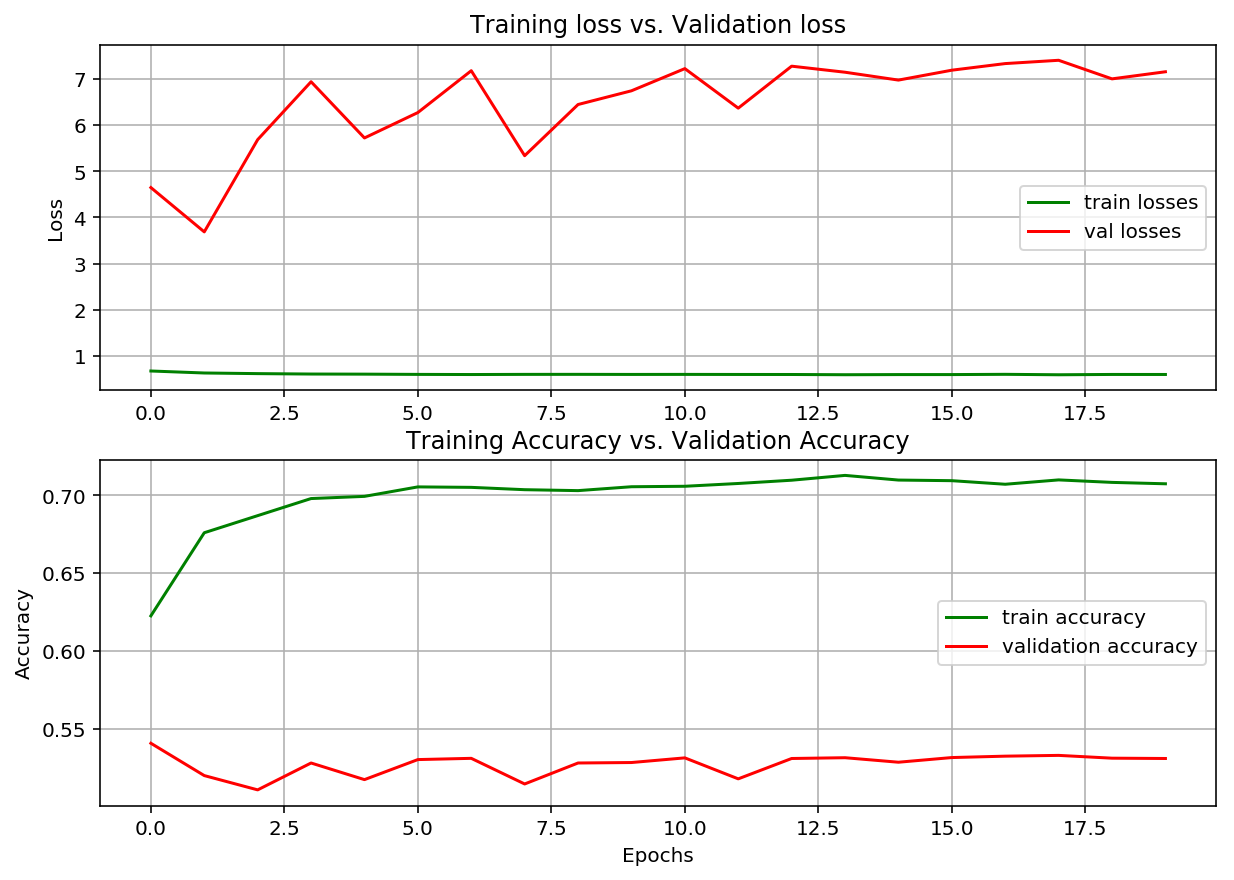

In [143]:
plt.figure(figsize=(10, 7))

# 训练与验证集的损失
loss = [0.6781, 0.6349, 0.6212, 0.6123, 0.6098, 0.6046, 0.6016, 0.6049, 0.6056, 0.6037, \
        0.6046, 0.6031, 0.6025, 0.5975, 0.6006, 0.6007, 0.6060, 0.5966, 0.6034, 0.6027]
val_loss = [4.6464, 3.6877, 5.6829, 6.9355, 5.7195, 6.2689, 7.1742, 5.3356, 6.4428, 6.7396, \
            7.2194, 6.3644, 7.2723, 7.1413, 6.9712, 7.1853, 7.3284, 7.3997, 6.9977, 7.1514]
plt.subplot(211)
plt.plot(loss, 'g', label="train losses")
plt.plot(val_loss, 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
# plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()

# 训练与验证的精确度
acc = [0.6225, 0.6760, 0.6870, 0.6980, 0.6994, 0.7055, 0.7052, 0.7037, 0.7031, 0.7056, 0.7059, \
       0.7077, 0.7098, 0.7129, 0.7099, 0.7095, 0.7072, 0.7100, 0.7084, 0.7075]
val_acc = [0.5405, 0.5197, 0.5105, 0.5278, 0.5171, 0.5300, 0.5308, 0.5143, 0.5278, 0.5281, 0.5311, \
           0.5176, 0.5307, 0.5312, 0.5283, 0.5313, 0.5322, 0.5327, 0.5309, 0.5307]
plt.subplot(212)
plt.plot(acc, 'g', label="train accuracy")
plt.plot(val_acc, 'r', label="validation accuracy")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()